In [53]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_points import *
from read_positions import read_positions
import largestinteriorrectangle as lir
from perspective import *
%matplotlib inline
from helper import *



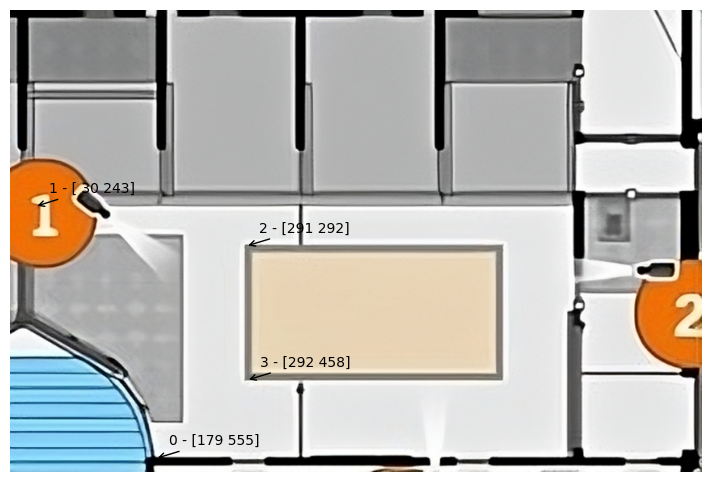

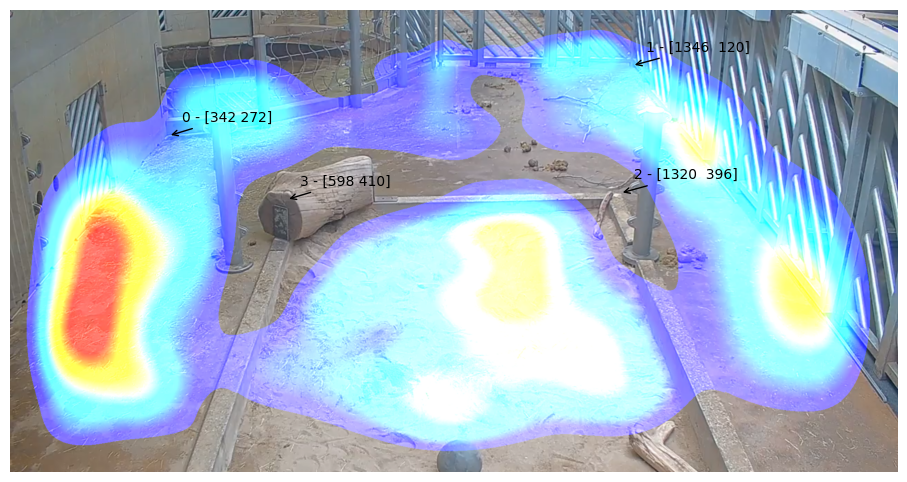

In [54]:
background = cv2.imread('back.jpeg')
plot_images(background)
for i, pt in enumerate(MAP_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))
img1 = cv2.imread('heat.png')
plot_images(img1)
for i, pt in enumerate(IMAGE_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

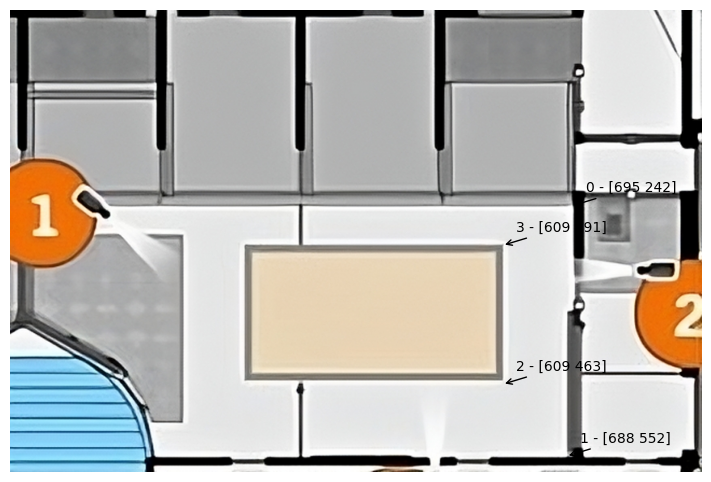

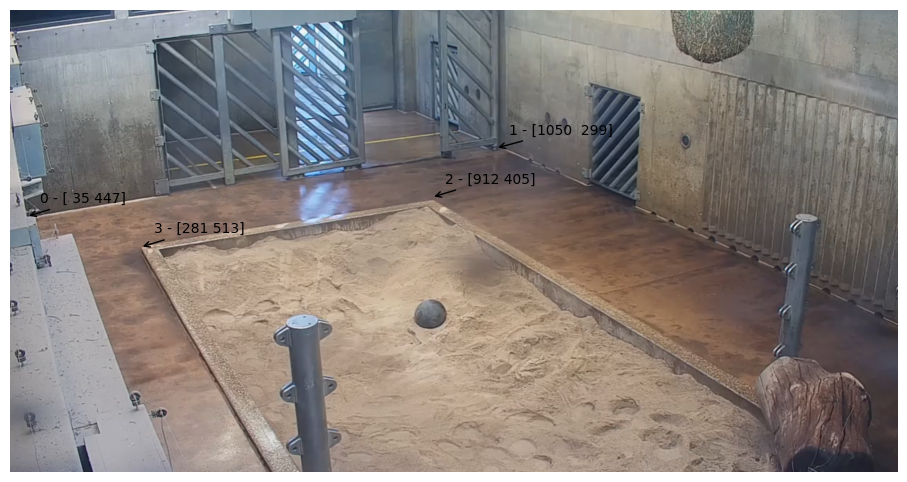

In [55]:
background = cv2.imread('back.jpeg')
plot_images(background)
for i, pt in enumerate(MAP_PTS_2):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))
img = cv2.imread('backgrounds/background2.png')
plot_images(img)
for i, pt in enumerate(IMAGE_PTS_2):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

572 856


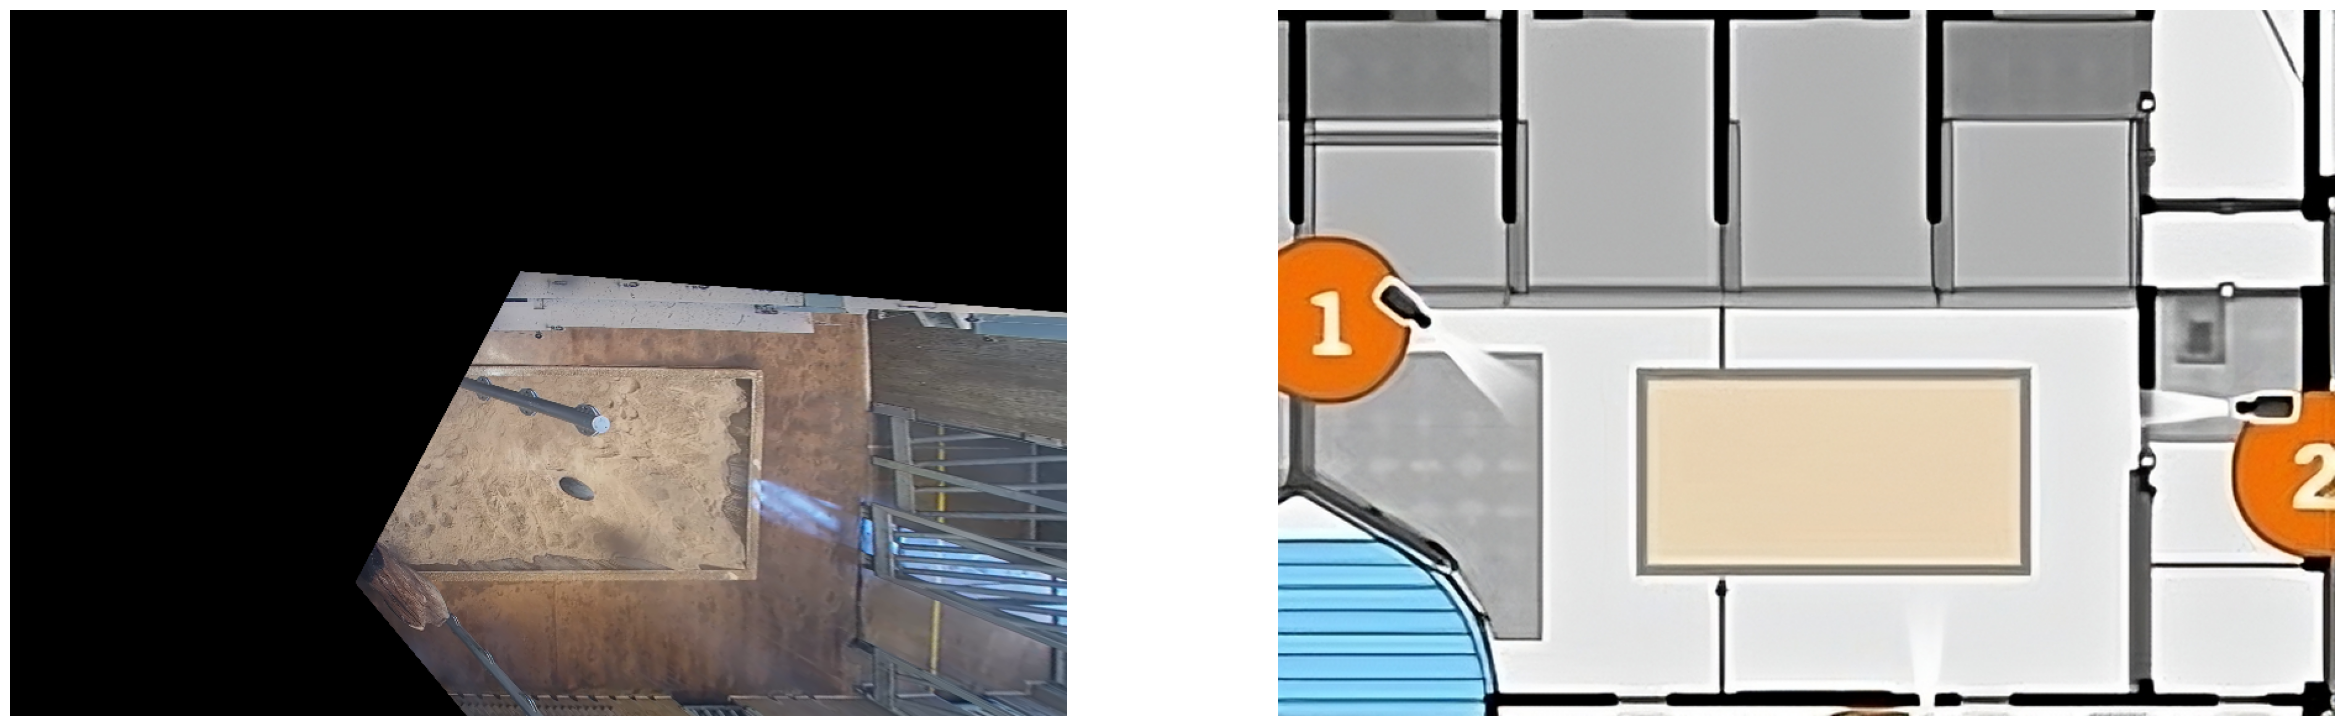

In [56]:
IMAGE_PTS_2 = np.array([[35, 447], [1050, 299], [912, 405], [281, 513]])
MAP_PTS_2 = np.array([[695, 242],  [688, 552], [609, 463], [609, 291]])

H, mask = cv2.findHomography(IMAGE_PTS_2, MAP_PTS_2)
height, width = background.shape[:2]
print(height, width)
dst = cv2.warpPerspective(img, H, (width, height))
plot_images(dst,background)

572 856


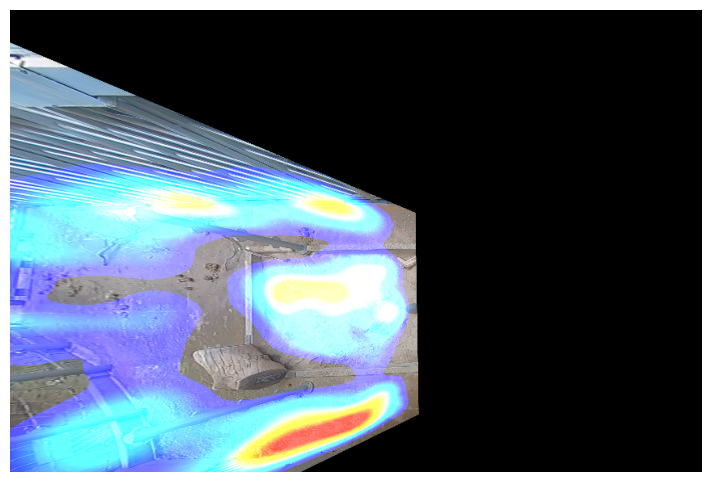

In [57]:
IMAGE_PTS_2 = np.array([[3, 447], [1055, 299], [915, 411], [284, 513]])
MAP_PTS_2 = np.array([[695, 242],  [688, 552], [609, 458], [609, 291]])

H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)
height, width = background.shape[:2]
print(height, width)
dst = cv2.warpPerspective(img1, H, (width, height))
plot_images(dst)


In [58]:
def shift(x, y, width, height):
    y += height/3
    return x, y, width, height


df = read_positions(label_dir='../../data/labels', output_csv='positions.csv')
df = df[(df['Camera'] == 1) | (df['Camera'] == 2)]
df.head(11)
# H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)

df_proj = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Point1', 'Point2', 'Point3', 'Point4'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    map_width, map_height = CAMERA_to_MAP[data['Camera']]
    H = CAMERA_to_H[data['Camera']]
    data['Date'] = row['Date']
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    # print(f'x, y, w, h = {x, y, width, height}')
    x, y, width, height = shift(x, y, width, height)
    x_proj, y_proj, polygon= transform_row2(H, x, y, width, height)

    map_width, map_height = MAP_WIDTH12, MAP_HEIGHT12
    polygon = [(x/map_width, y/map_height) for x, y in polygon]
    # print(polygon)  
    data['X_center'], data['Y_center'] = x_proj/map_width, y_proj/map_height
    for idx, col in enumerate(['Point1', 'Point2', 'Point3', 'Point4']):
        data[col] = polygon[idx]
    
    df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)
df_proj.head()

/tmp/ipykernel_1602686/527684409.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)


Camera                Date  X_center  Y_center  \
0      2 2024-01-25 17:30:00  0.521538  0.857321   
1      2 2024-01-25 17:30:00  0.428869  0.901539   
2      2 2024-01-29 16:30:00  0.469200  0.901225   
3      2 2024-01-29 16:30:00  0.569504  0.867610   
4      2 2024-01-29 02:45:00  0.428438  0.575552   

                                      Point1  \
0   (0.6550795653156031, 0.8951674241286057)   
1   (0.5709940473609996, 1.0114516678389969)   
2   (0.5723639158444984, 0.9311480755572552)   
3   (0.7552323385933849, 0.9549952153559331)   
4  (0.47633040954019423, 0.5525225659350416)   

                                     Point2  \
0  (0.5939847999644057, 1.0525972593080748)   
1  (0.5188731968959915, 1.1470315573098777)   
2  (0.5162348880946079, 1.0782027878127731)   
3  (0.6947125586393837, 1.1064593975360577)   
4   (0.444410021059981, 0.6411664202496722)   

                                      Point3  \
0   (0.4297821544041143, 0.8313166478297094)   
1   (0.3417407953850577, 0.8341576636254371)   
2  (0.39417634054879164, 0.8794644762586047)   
3     (0.454726210264402, 0.813606742378715)   
4   (0.3877763480783623, 0.5951040307958643)   

                                      Point4  
0   (0.4705045468339296, 0.7197648161774749)  
1   (0.3725396628691771, 0.7478964745581567)  
2     (0.43416802236967, 0.7694117406031469)  
3  (0.49031983134902524, 0.7165558288147399)  
4    (0.4146747054340683, 0.519012451171875)

In [59]:
len(set(df[df['Camera'] == 1].Date.unique()).intersection(df[df['Camera'] == 2].Date.unique()))

130

In [60]:
# def calculate_iou(boxA, boxB):
#     """
#     Calculate the Intersection over Union (IoU) of two bounding boxes.

#     Parameters:
#     - boxA: The first bounding box as a tuple (x, y, width, height)
#     - boxB: The second bounding box as a tuple (x, y, width, height)

#     Returns:
#     - The IoU as a float. This will be 0 if the boxes do not intersect.
#     """
#     # Determine the coordinates of the intersection rectangle
#     xA = max(boxA[0], boxB[0])
#     yA = max(boxA[1], boxB[1])
#     xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
#     yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

#     # Compute the area of intersection rectangle
#     interArea = max(0, xB - xA) * max(0, yB - yA)

#     # Compute the area of both the bounding boxes
#     boxAArea = boxA[2] * boxA[3]
#     boxBArea = boxB[2] * boxB[3]

#     # Compute the union area by adding both areas and subtracting the intersection area
#     unionArea = boxAArea + boxBArea - interArea

#     # Compute the IoU
#     iou = interArea / unionArea

#     return iou

Camera                                             1
Date                             2024-02-05 17:45:00
X_center                                    0.520611
Y_center                                    0.472137
Point1       (0.390685464734229, 0.5175571575031414)
Point2      (0.3953002501870984, 0.3190967586490658)
Point3      (0.596870850179797, 0.44547666536344516)
Point4      (0.5984518461138288, 0.5672030148806272)
Name: 130, dtype: object
0
Camera                                             1
Date                             2024-02-05 17:45:00
X_center                                     0.49474
Y_center                                    0.836396
Point1      (0.39761619924384856, 0.937787249371722)
Point2      (0.39990772710782346, 0.826171181418679)
Point3       (0.5601224453649788, 0.768139499050754)
Point4      (0.5605840593854957, 0.8434947087214544)
Name: 131, dtype: object
1
Camera                                              1
Date                              2024-02-05

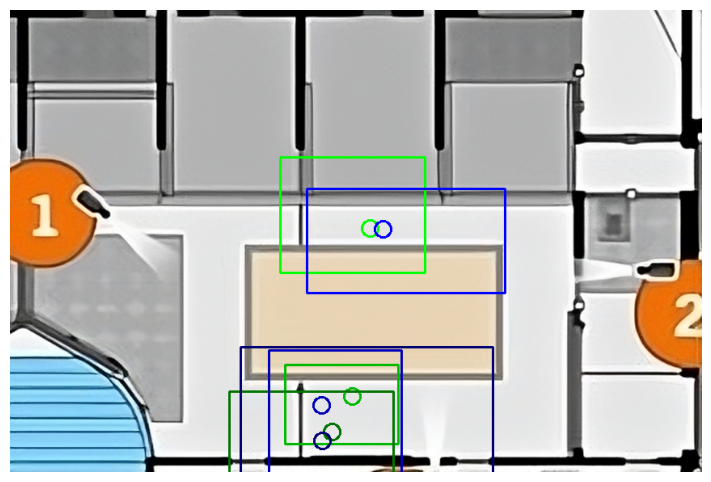

In [61]:
def draw_bounding_rect(image, bounding_rect, col=(0, 255, 0)):
    """
    Draws a rectangle on the image based on the bounding rectangle parameters.

    Parameters:
    - image: The image on which to draw the rectangle.
    - bounding_rect: A tuple of the form (x, y, w, h) representing the top-left corner coordinates,
                     width, and height of the bounding rectangle.
    """
    x, y, w, h = bounding_rect
    
    # Draw the rectangle on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), col, 2)

df = df_proj
#common_dates = set(df[df['Camera'] == 1].Date.unique()).intersection(df[df['Camera'] == 2].Date.unique())


heatmap_width, heatmap_height = 856, 572
def f():
    background = cv2.imread('back.jpeg')
    cnt = 0
    for i, x in enumerate(common_dates):
        #print(i, x)
        similar = df[df['Date']==pd.to_datetime(x)]
        #print(similar)
        ones = similar[similar['Camera']==1]
        #print(ones)
        twos = similar[similar['Camera'] == 2]
        for idx, (_, o) in enumerate(ones.iterrows()):
            print(o)
            
            c1 = (o['X_center'], o['Y_center'])
            #distance = np.linalg.norm(np.array(c1) - np.array(c2))
            cols = ['Point1', 'Point2', 'Point3', 'Point4']
            polygon1 = [(float(o[col][0])*heatmap_width, float(o[col][1]) *heatmap_height) for col in cols]
            vertices1 = np.array(polygon1, dtype=np.int32)
            c1 = (c1[0]*heatmap_width, c1[1]*heatmap_height)
            draw_circle(background, c1[0], c1[1], 10, (0,255-70*idx,0))
            print(idx)
            draw_bounding_rect(background, cv2.boundingRect(vertices1), (0,255-70*idx, 0))
            
        for idx, (_, o) in enumerate(twos.iterrows()):
            print(o)
            
            c1 = (o['X_center'], o['Y_center'])
            #distance = np.linalg.norm(np.array(c1) - np.array(c2))
            cols = ['Point1', 'Point2', 'Point3', 'Point4']
            polygon1 = [(float(o[col][0])*heatmap_width, float(o[col][1]) *heatmap_height) for col in cols]
            vertices1 = np.array(polygon1, dtype=np.int32)
            c1 = (c1[0]*heatmap_width, c1[1]*heatmap_height)
            draw_circle(background, c1[0], c1[1], 10, (255-70*idx,0, 0))
            print(idx)
            draw_bounding_rect(background, cv2.boundingRect(vertices1), (255-70*idx, 0, 0))
    plot_images(background)
            
        
        # for idx1, o in ones.iterrows():
        #     for idx2, t in twos.iterrows():
        #         c1 = (o['X_center'], o['Y_center'])
        #         c2 = (t['X_center'], t['Y_center'])
        #         distance = np.linalg.norm(np.array(c1) - np.array(c2))
        #         cols = ['Point1', 'Point2', 'Point3', 'Point4']
        #         polygon1 = [(float(o[col][0])*heatmap_width, float(o[col][1]) *heatmap_height) for col in cols]
        #         polygon2 = [(float(t[col][0])*heatmap_width, float(t[col][1]) *heatmap_height) for col in cols]
        #         vertices1 = np.array(polygon1, dtype=np.int32)
        #         vertices2 = np.array(polygon2, dtype=np.int32)
        #         c1 = (c1[0]*heatmap_width, c1[1]*heatmap_height)
        #         c2 = (c2[0]*heatmap_width, c2[1]*heatmap_height)
                
        #         # print(f'IOU = {calculate_iou(cv2.boundingRect(vertices1), cv2.boundingRect(vertices2))}')
        #         if distance <= 0.1 and calculate_iou(cv2.boundingRect(vertices1), cv2.boundingRect(vertices2)) > 0.25:
        #             print(distance)
        #             background = cv2.imread('back.jpeg')
        #             print(f'IOU = {calculate_iou(cv2.boundingRect(vertices1), cv2.boundingRect(vertices2))}')
        #             # plot_images(background)
        #             if cnt <= 15:
        #                 draw_bounding_rect(background, cv2.boundingRect(vertices1))
        #                 draw_bounding_rect(background, cv2.boundingRect(vertices2), (255,0,0))
        #                 draw_circle(background, c1[0], c1[1], 10, (0,255,0))
        #                 draw_circle(background, c2[0], c2[1], 10, (255,0,0))
        #                 plot_images(background)
        #                 cnt+=1
                        
                
                
                    
            
            
            
    
    
f()

In [62]:
common_dates = {pd.Timestamp('2024-02-05 17:45:00')}

In [63]:
# img1 = cv2.imread('../../data/images/screenshot1_05_02__16_45.png')
# img2 = cv2.imread('../../data/images/screenshot2_05_02__16_45.png')
# plot_images(img1, img2)

0.01898970546731789
IOU = 0.3613689371221857
0.04822462639878203
IOU = 0.49502092654062635
0.05953332003014188
IOU = 0.49453001687258474
0.02366064966990918
IOU = 0.22800604991177212


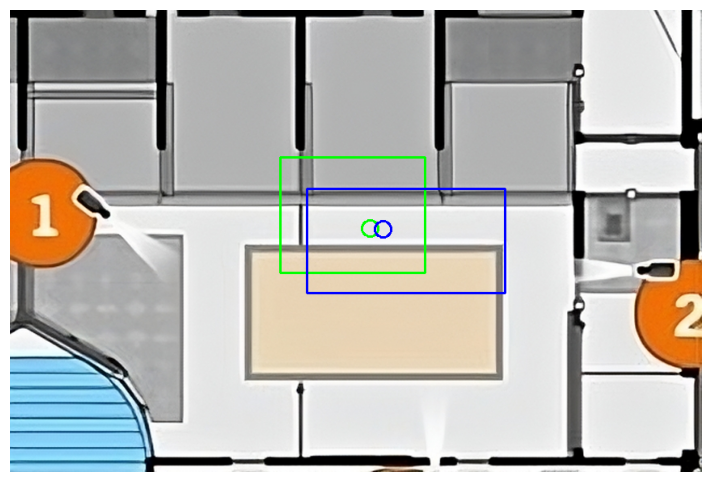

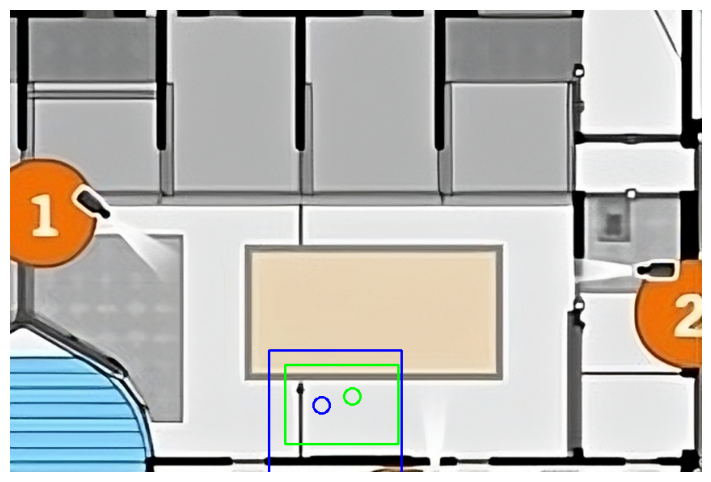

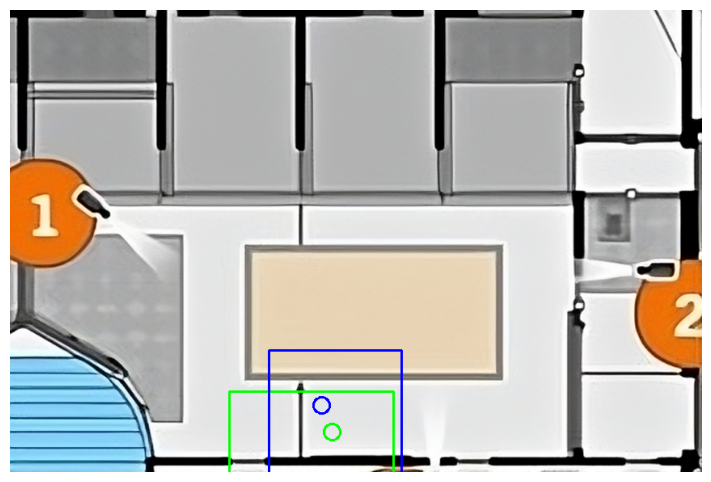

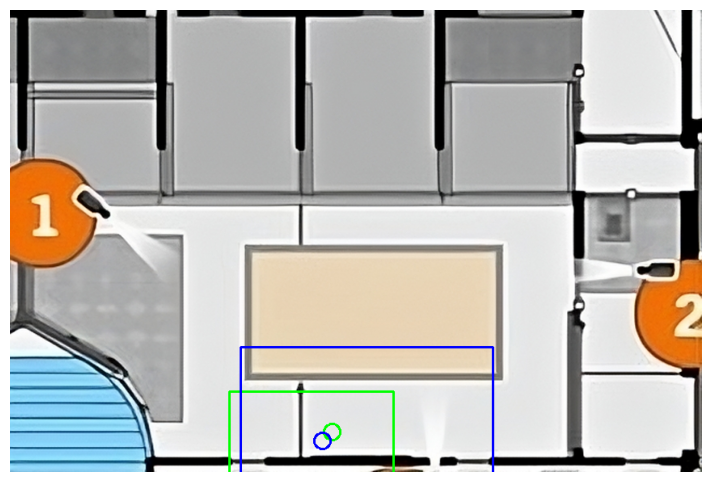

In [64]:
def draw_bounding_rect(image, bounding_rect, col=(0, 255, 0)):
    """
    Draws a rectangle on the image based on the bounding rectangle parameters.

    Parameters:
    - image: The image on which to draw the rectangle.
    - bounding_rect: A tuple of the form (x, y, w, h) representing the top-left corner coordinates,
                     width, and height of the bounding rectangle.
    """
    x, y, w, h = bounding_rect
    
    # Draw the rectangle on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), col, 2)

df = df_proj
#common_dates = set(df[df['Camera'] == 1].Date.unique()).intersection(df[df['Camera'] == 2].Date.unique())


heatmap_width, heatmap_height = 856, 572
def f():
    background = cv2.imread('back.jpeg')
    cnt = 0
    for i, x in enumerate(common_dates):
        #print(i, x)
        similar = df[df['Date']==pd.to_datetime(x)]
        #print(similar)
        ones = similar[similar['Camera']==1]
        #print(ones)
        twos = similar[similar['Camera'] == 2]
            
        
        for idx1, o in ones.iterrows():
            for idx2, t in twos.iterrows():
                c1 = (o['X_center'], o['Y_center'])
                c2 = (t['X_center'], t['Y_center'])
                distance = np.linalg.norm(np.array(c1) - np.array(c2))
                cols = ['Point1', 'Point2', 'Point3', 'Point4']
                polygon1 = [(float(o[col][0])*heatmap_width, float(o[col][1]) *heatmap_height) for col in cols]
                polygon2 = [(float(t[col][0])*heatmap_width, float(t[col][1]) *heatmap_height) for col in cols]
                vertices1 = np.array(polygon1, dtype=np.int32)
                vertices2 = np.array(polygon2, dtype=np.int32)
                c1 = (c1[0]*heatmap_width, c1[1]*heatmap_height)
                c2 = (c2[0]*heatmap_width, c2[1]*heatmap_height)
                
                # print(f'IOU = {calculate_iou(cv2.boundingRect(vertices1), cv2.boundingRect(vertices2))}')
                if distance <= 0.1 and calculate_iou(cv2.boundingRect(vertices1), cv2.boundingRect(vertices2)) > 0.05:
                    print(distance)
                    background = cv2.imread('back.jpeg')
                    print(f'IOU = {calculate_iou(cv2.boundingRect(vertices1), cv2.boundingRect(vertices2))}')
                    # plot_images(background)
                    if cnt <= 15:
                        draw_bounding_rect(background, cv2.boundingRect(vertices1))
                        draw_bounding_rect(background, cv2.boundingRect(vertices2), (255,0,0))
                        draw_circle(background, c1[0], c1[1], 10, (0,255,0))
                        draw_circle(background, c2[0], c2[1], 10, (255,0,0))
                        plot_images(background)
                        cnt+=1
                        
                    
            
            
            
    
    
f()

In [73]:
x = pd.Timestamp('2024-02-05 17:45:00')
df = df_proj.copy()
similar = df[df['Date']==pd.to_datetime(x)]
similar

Camera                Date  X_center  Y_center  \
130       1 2024-02-05 17:45:00  0.520611  0.472137   
131       1 2024-02-05 17:45:00  0.494740  0.836396   
132       1 2024-02-05 17:45:00  0.465053  0.912634   
1157      2 2024-02-05 17:45:00  0.539354  0.475184   
1158      2 2024-02-05 17:45:00  0.450237  0.854974   
1159      2 2024-02-05 17:45:00  0.451453  0.931995   

                                        Point1  \
130    (0.390685464734229, 0.5175571575031414)   
131   (0.39761619924384856, 0.937787249371722)   
132    (0.31775315899715245, 1.05918788243007)   
1157  (0.7141123263635368, 0.4248296297513522)   
1158  (0.5646307401567976, 0.9398152811543925)   
1159  (0.6971497580269786, 1.1637024779419798)   

                                         Point2  \
130    (0.3953002501870984, 0.3190967586490658)   
131    (0.39990772710782346, 0.826171181418679)   
132   (0.32152724934515553, 0.9444611022522399)   
1157   (0.6436703405647635, 0.6116203894981971)   
1158    (0.530338109096634, 1.0297567727682473)   
1159   (0.6263414899879527, 1.3398561277589598)   

                                        Point3  \
130   (0.596870850179797, 0.44547666536344516)   
131    (0.5601224453649788, 0.768139499050754)   
132   (0.5527882798809871, 0.8253426718545127)   
1157  (0.42962471792631063, 0.506800938319493)   
1158  (0.3738746643066406, 0.7983381898253115)   
1159  (0.3331201143353899, 0.8204002113609047)   

                                         Point4  
130    (0.5984518461138288, 0.5672030148806272)  
131    (0.5605840593854957, 0.8434947087214544)  
132    (0.5531169142678519, 0.8931054068612052)  
1157  (0.47203830469434505, 0.3871405808242051)  
1158   (0.3960101047408915, 0.7366481861034473)  
1159   (0.3650821079717618, 0.7305681455385434)

1157    0.018990
1158    0.389251
1159    0.465030
dtype: float64
0.01898970546731789
[1157]


Camera                Date  X_center  Y_center  \
130       1 2024-02-05 17:45:00  0.520611  0.472137   
131       1 2024-02-05 17:45:00  0.494740  0.836396   
132       1 2024-02-05 17:45:00  0.465053  0.912634   
1158      2 2024-02-05 17:45:00  0.450237  0.854974   
1159      2 2024-02-05 17:45:00  0.451453  0.931995   

                                        Point1  \
130    (0.390685464734229, 0.5175571575031414)   
131   (0.39761619924384856, 0.937787249371722)   
132    (0.31775315899715245, 1.05918788243007)   
1158  (0.5646307401567976, 0.9398152811543925)   
1159  (0.6971497580269786, 1.1637024779419798)   

                                         Point2  \
130    (0.3953002501870984, 0.3190967586490658)   
131    (0.39990772710782346, 0.826171181418679)   
132   (0.32152724934515553, 0.9444611022522399)   
1158    (0.530338109096634, 1.0297567727682473)   
1159   (0.6263414899879527, 1.3398561277589598)   

                                        Point3  \
130   (0.596870850179797, 0.44547666536344516)   
131    (0.5601224453649788, 0.768139499050754)   
132   (0.5527882798809871, 0.8253426718545127)   
1158  (0.3738746643066406, 0.7983381898253115)   
1159  (0.3331201143353899, 0.8204002113609047)   

                                        Point4  
130   (0.5984518461138288, 0.5672030148806272)  
131   (0.5605840593854957, 0.8434947087214544)  
132   (0.5531169142678519, 0.8931054068612052)  
1158  (0.3960101047408915, 0.7366481861034473)  
1159  (0.3650821079717618, 0.7305681455385434)

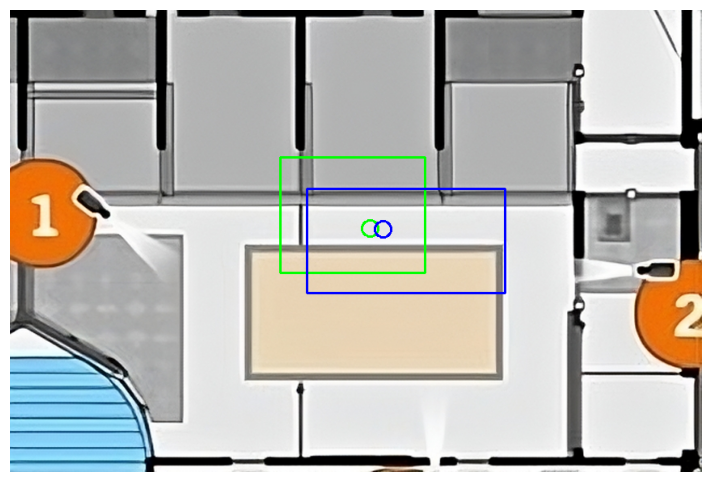

In [85]:

def calculate_distance(row1, row2):
    """Calculate the Euclidean distance between two points."""
    return np.linalg.norm(np.array([row1['X_center'], row1['Y_center']]) - np.array([row2['X_center'], row2['Y_center']]))

def remove_duplicate_elephants(df, threshold):
    # Ensure the 'Date' column is in datetime format
    #df['Date'] = pd.to_datetime(df['Date'])
    
    # Prepare a list to track indices to remove
    indices_to_remove = []

    # Iterate through each unique timestamp
    for timestamp in df['Date'].unique():
        # Filter entries for this specific timestamp for both cameras
        cam1_entries = df[(df['Camera'] == 1) & (df['Date'] == timestamp)]
        cam2_entries = df[(df['Camera'] == 2) & (df['Date'] == timestamp)]
        
        # Nested loop to calculate distances between all cam1 and cam2 entries
        for index1, row1 in cam1_entries.iterrows():
            for index2, row2 in cam2_entries.iterrows():
                distance = calculate_distance(row1, row2)
                
                # If distance is within threshold, check mutual closeness
                if distance < threshold:
                    # Find closest cam2 entry to current cam1 entry
                    
                    closest_to_cam1 = cam2_entries.apply(lambda row: calculate_distance(row, row1), axis=1).idxmin()
                    print(cam2_entries.apply(lambda row: calculate_distance(row, row1), axis=1))
                    # Find closest cam1 entry to current cam2 entry
                    closest_to_cam2 = cam1_entries.apply(lambda row: calculate_distance(row, row2), axis=1).idxmin()
                    
                    # Check mutual closeness
                    if closest_to_cam1 == index2 and closest_to_cam2 == index1:
                        assert index2 not in indices_to_remove
                        indices_to_remove.append(index2)  # Add cam2 entry to removal list
                        c1 = (row1['X_center'], row1['Y_center'])
                        c2 = (row2['X_center'], row2['Y_center'])
                        print(distance)
                        cols = ['Point1', 'Point2', 'Point3', 'Point4']
                        polygon1 = [(float(row1[col][0])*heatmap_width, float(row1[col][1]) *heatmap_height) for col in cols]
                        polygon2 = [(float(row2[col][0])*heatmap_width, float(row2[col][1]) *heatmap_height) for col in cols]
                        vertices1 = np.array(polygon1, dtype=np.int32)
                        vertices2 = np.array(polygon2, dtype=np.int32)
                        c1 = (c1[0]*heatmap_width, c1[1]*heatmap_height)
                        c2 = (c2[0]*heatmap_width, c2[1]*heatmap_height)
                        background = cv2.imread('back.jpeg')
                        draw_bounding_rect(background, cv2.boundingRect(vertices1))
                        draw_bounding_rect(background, cv2.boundingRect(vertices2), (255,0,0))
                        draw_circle(background, c1[0], c1[1], 10, (0,255,0))
                        draw_circle(background, c2[0], c2[1], 10, (255,0,0))
                        plot_images(background)
            break

    # Remove duplicates from the list
    #indices_to_remove = list(set(indices_to_remove))
    print(indices_to_remove)

    # Drop the entries from the original DataFrame
    df_cleaned = df.drop(indices_to_remove)
    
    return df_cleaned

# Example usage
threshold = 0.1  # Adjust the threshold as needed
df_cleaned = remove_duplicate_elephants(similar, threshold)
df_cleaned
